# Wine Quality Prediction with Watson Natural Language Understanding

### Authored By: Elliott Botwick - elliott.botwick@ibm.com

In [1]:
import pandas as pd
import numpy as np
import sklearn
import boto3
import io
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# The code was removed by Watson Studio for sharing.

In [3]:
# The code was removed by Watson Studio for sharing.

In [4]:
#Read in data from S3 bucket
s3 = boto3.client('s3', aws_access_key_id=s3_access_key,aws_secret_access_key=s3_secret_key)
wine_data_obj = s3.get_object(Bucket='edb-demos', Key='winemag-data_first150k.csv')

wine = pd.read_csv(io.BytesIO(wine_data_obj['Body'].read()))
wine.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


## Basic EDA - data shape, description of continuous variables,  and some histograms

In [5]:
#print number of rows and columns
print("Data has {} rows and {} columns".format(wine.shape[0], wine.shape[1]))

Data has 150930 rows and 10 columns


In [6]:
#see descriptive statistics of numerical cols
wine.describe()

,points,price
count,150930.000000,137235.000000
mean,87.888418,33.131482
std,3.222392,36.322536
min,80.000000,4.000000
25%,86.000000,16.000000
50%,88.000000,24.000000
75%,90.000000,40.000000
max,100.000000,2300.000000


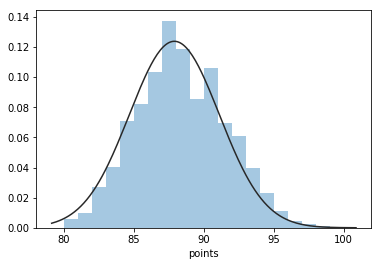

In [7]:
#Points look to be nicely distributed from 80 to 100 points
from scipy.stats import norm
sns.distplot(wine.points, bins = 20, kde = False, fit = norm)

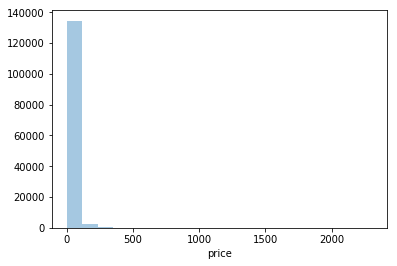

In [8]:
#Price data looks extremely skewed however...
sns.distplot(wine[wine.price.notna()].price, bins = 20,  kde = False)

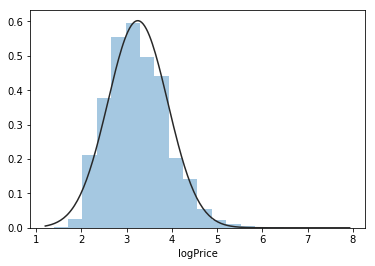

In [9]:
#Can we get a more normal looking distribution of price by taking the log?
import math
wine['logPrice'] = (wine['price'].apply(lambda x: math.log(x)))

sns.distplot(wine[wine.logPrice.notna()].logPrice, bins = 20, kde = False, fit = norm)

## Check how many null values are in each variable then visualize it

In [10]:
print("Proportion of Null Values in Each Column")
print(np.around(wine.isna().sum()/wine.shape[0]*100, 3))
NAlist = np.around(wine.isna().sum()/wine.shape[0], 4).values*100


na_country = np.array([NAlist[0], 100- NAlist[0]])
na_description = np.array([NAlist[1], 100- NAlist[1]])
na_designation = np.array([NAlist[2], 100- NAlist[2]])

na_points = np.array([NAlist[3], 100- NAlist[3]])
na_price = np.array([NAlist[4], 100- NAlist[4]])

na_province = np.array([NAlist[5], 100- NAlist[5]])
na_region_1 = np.array([NAlist[6], 100- NAlist[6]])
na_region_2 = np.array([NAlist[7], 100- NAlist[7]])

na_variety = np.array([NAlist[8], 100- NAlist[8]])
na_winery = np.array([NAlist[9], 100- NAlist[9]])

NA_pairs_list = [na_country, na_description, na_designation, na_points, na_price, na_province, na_region_1, na_region_2, na_variety, na_winery]

Proportion of Null Values in Each Column
country         0.003
description     0.000
designation    30.302
points          0.000
price           9.074
province        0.003
region_1       16.604
region_2       59.615
variety         0.000
winery          0.000
logPrice        9.074
dtype: float64


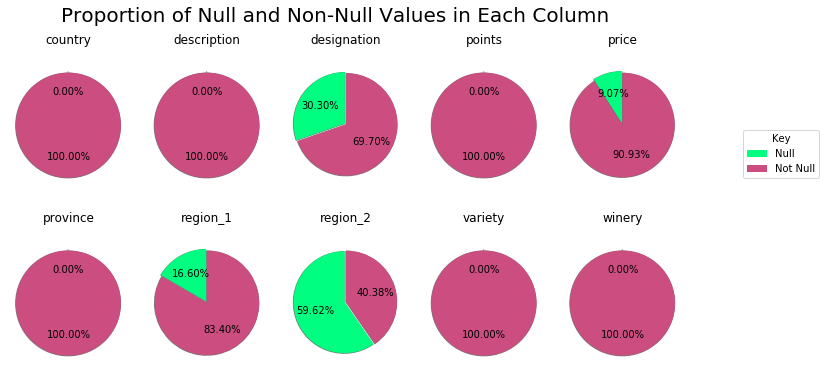

In [11]:
from matplotlib import pyplot as plt

fig, axes= plt.subplots(2, 5)
fig.set_size_inches(12,6)
fig.suptitle("Proportion of Null and Non-Null Values in Each Column", fontsize=20)
for i, ax in enumerate(axes.flatten()):
    ax.pie(NA_pairs_list[i], autopct="%.2f%%", explode = (0,0.1), pctdistance=0.6, shadow = True, radius = 3,startangle=90, colors = [[0,1, 0.5], [0.8, 0.3, 0.5]])
    ax.set_title(wine.columns[i])
    ax.axis('equal')
    
ax.legend(['Null', 'Not Null'],
          title="Key",
          loc="center left",
          bbox_to_anchor=(1.5, 1, 0, 1))
plt.show()

In [12]:
#only 5 rows without country or province, we'll go ahead and get rid of those
wine.dropna(subset = ['country', 'province'], inplace = True)

In [13]:
#Itereate through all province values and write the most common 'region_1' value for that province to a dict (along with the province name)
#If there are no regions for a particular province (often this was the case) then populate dict with 'NoListedRegion'
## i.e. find the most common region in California, Northern Spain, Tuscany etc. and write it as a key value pair

regionDict = {}
for p in wine.province.value_counts().index:
    if len(wine[wine.province ==p].region_1.value_counts()) < 1:
        regionDict.update({p: 'NoListedRegion'})
    else:
        regionDict.update({p:  wine[wine.province == p].region_1.value_counts().index[0]})

In [16]:
#Fill NA values in Region 1 by looking up the associated province and finding the most common region for that province in the regionDict
tqdm.pandas()
wine['region_1_imputed'] = wine[['province', 'region_1']].progress_apply(lambda row: row.fillna(value = regionDict.get(row['province'])), axis = 1).loc[:, 'region_1']

100%|██████████| 150925/150925 [01:21<00:00, 1848.91it/s]


In [17]:
#Check to see region_1_imputed has no null values
wine.isna().sum()

country                 0
description             0
designation         45735
points                  0
price               13695
province                0
region_1            25055
region_2            89972
variety                 0
winery                  0
logPrice            13695
region_1_imputed        0
dtype: int64

## Check how many distinct values are in each categorical var then visualize it

In [18]:
#Loop through cateorical variables and print number of distinct values and append proportion of distinct values to a list
wine_cats = wine.columns[wine.dtypes.values=="O"]
uniqueList = []
for c in wine_cats:
    print("{} has {} distinct values, {}% of values unique".format(c, len(wine[c].value_counts()), np.around(len(wine[c].value_counts())/wine.shape[0]*100,2)))
    uniqueList.append(np.around(len(wine[c].value_counts())/wine.shape[0]*100,2))

country has 48 distinct values, 0.03% of values unique
description has 97818 distinct values, 64.81% of values unique
designation has 30617 distinct values, 20.29% of values unique
province has 455 distinct values, 0.3% of values unique
region_1 has 1236 distinct values, 0.82% of values unique
region_2 has 18 distinct values, 0.01% of values unique
variety has 632 distinct values, 0.42% of values unique
winery has 14809 distinct values, 9.81% of values unique
region_1_imputed has 1237 distinct values, 0.82% of values unique


In [19]:
uni_country = np.array([uniqueList[0], 100- uniqueList[0]])
uni_description = np.array([uniqueList[1], 100- uniqueList[1]])

uni_designation = np.array([uniqueList[2], 100- uniqueList[2]])
uni_province = np.array([uniqueList[3], 100- uniqueList[3]])

uni_region_1 = np.array([uniqueList[4], 100- uniqueList[4]])
uni_region_2 = np.array([uniqueList[5], 100- uniqueList[5]])

uni_variety = np.array([uniqueList[6], 100- uniqueList[6]])
uni_winery = np.array([uniqueList[7], 100- uniqueList[7]])

unique_pairs_list = [uni_country, uni_description, uni_designation, uni_province, uni_region_1, uni_region_2, uni_variety, uni_winery]

labels = ('Unique', 'Non-Unique')

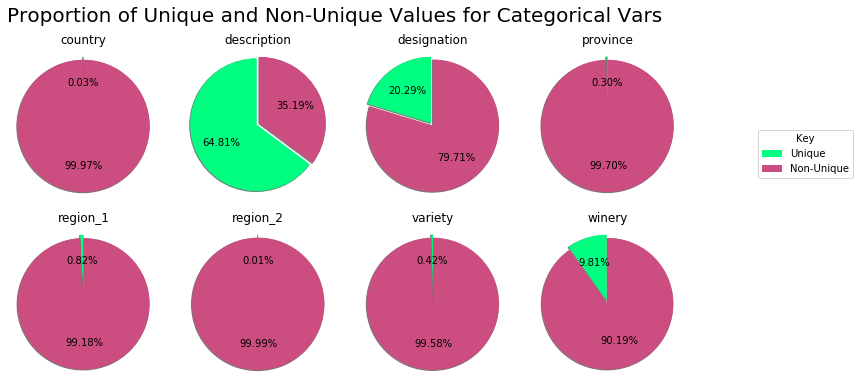

In [20]:
fig, axes= plt.subplots(2, 4)
fig.set_size_inches(12,6)
fig.suptitle("Proportion of Unique and Non-Unique Values for Categorical Vars", fontsize=20)
for i, ax in enumerate(axes.flatten()):
    ax.pie(unique_pairs_list[i], autopct="%.2f%%", explode = (0,0.1), pctdistance=0.6, shadow = True, radius = 2,startangle=90, colors = [[0,1, 0.5], [0.8, 0.3, 0.5]])
    ax.set_title(wine_cats[i])
    ax.axis('equal')
    
ax.legend(labels,
          title="Key",
          loc="center left",
          bbox_to_anchor=(1.5, 1, 0, 1))
plt.show()

### From above we can see that the most distinct column is description - but description should actually be almost 100% unique, so we will check for duplicates

In [21]:
#look for rows that have the same description, winery, variety, country and province
wine[(wine.duplicated(subset = ['description', 'winery', 'variety','country', 'province']))].sort_values(by = 'description').tail(10)

,country,description,designation,points,price,province,region_1,region_2,variety,winery,logPrice,region_1_imputed
105595,South Africa,“The Affair” refers to the relationship betwee...,Temptation The Affair,84,28.0,Walker Bay,NaN,NaN,Red Blend,La Vierge,3.332205,NoListedRegion
130465,South Africa,“The Affair” refers to the relationship betwee...,Temptation The Affair,84,28.0,Walker Bay,NaN,NaN,Red Blend,La Vierge,3.332205,NoListedRegion
71865,Italy,“Three winds” is a new product from a top Pros...,Tre Venti Brut Millesimato,88,26.0,Veneto,Conegliano Valdobbiadene Prosecco Superiore,NaN,Glera,Zardetto,3.258097,Conegliano Valdobbiadene Prosecco Superiore
110992,Austria,“Trie” is a play on Gunter Triebaumer's red bl...,Trie,86,14.0,Neusiedlersee-Hügelland,NaN,NaN,Red Blend,Gunter Triebaumer,2.639057,NoListedRegion
133342,Austria,“Trie” is a play on Gunter Triebaumer's red bl...,Trie,86,14.0,Neusiedlersee-Hügelland,NaN,NaN,Red Blend,Gunter Triebaumer,2.639057,NoListedRegion
114857,Italy,“T” is a no-fuss Friulano (a native grape of n...,T,86,18.0,Northeastern Italy,Collio,NaN,Friulano,Eugenio Collavini,2.890372,Collio
137897,Italy,“T” is a no-fuss Friulano (a native grape of n...,T,86,18.0,Northeastern Italy,Collio,NaN,Friulano,Eugenio Collavini,2.890372,Collio
90355,US,“Whole cluster” refers to the fermentation pra...,Whole Cluster,88,40.0,California,Arroyo Grande Valley,Central Coast,Pinot Noir,Laetitia,3.688879,Arroyo Grande Valley
137095,Italy,“Wine for Seafood” is a Trebbiano-based wine f...,Wine for Seafood,80,11.0,Italy Other,Italy,NaN,Trebbiano,Wine for Food,2.397895,Italy
143214,Australia,“Wine for a new world” says the wine's tagline...,NaN,81,8.0,Australia Other,South Eastern Australia,NaN,Shiraz,Broken Earth,2.079442,South Eastern Australia


In [22]:
#drop rows that have the same description, winery, variety, country, and province
wine.drop_duplicates(subset = ['description', 'winery', 'variety', 'country', 'province'],inplace = True)

In [23]:
#see new shape of df, looks like almost 50k rows were duplicates unfortunately
wine.shape

(97840, 12)

### Compute continous then categorical feature correlations

In [24]:
#Our correlation matrix shows that logPrice has a high positive correlation with points 
wine.corr()

,points,price,logPrice
points,1.00000,0.447370,0.610910
price,0.44737,1.000000,0.763185
logPrice,0.61091,0.763185,1.000000


In [25]:
#compute cramers v paramater via scipy libraries
import scipy.stats as ss
def cramers_v(x, y):
    '''
    INPUT:
    X, Y - Arrays of cateorical data
    OUTPUT:
    cramers v coefficient - (0,1 ) anassociation measure for categorical variables
    
    Provides a measure of association between two categorical variables. Often strengths of associations are broken down as follows
    v = 0: No association
    v < 0.25: Weak association
    V > 0.75: Strong association 
    V = 1: Perfect association 
    '''
    
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [26]:
#cast points variable into a string so can use it in cramers v function
wine['pointsString'] = wine.points.astype(str)

In [27]:
#loop through categorical var list, compute correlation coefficients, then write variable name and correlation to a dict and print the dict sorted by correlation strength
### Note - these cramer's V correlation coefficients are not directly comprarble with the pearson correlations given in the df.corr() method above
catfeaturecorrs = {}
for k in wine_cats:
#         print("correlation between" ,k, "and Wine Quality is: ", cramers_v(wine[k], wine['pointsString']))
        catfeaturecorrs.update({k: cramers_v(wine[k], wine['pointsString'])})
    
sorted(catfeaturecorrs.items(), key = lambda x: x[1])

[('description', 0.013116840995146296),
 ('designation', 0.05145101118998346),
 ('country', 0.06786349667682219),
 ('variety', 0.07877322560096484),
 ('province', 0.0947013696189112),
 ('region_2', 0.0967776476433929),
 ('region_1_imputed', 0.15087823090206928),
 ('region_1', 0.1585957285631069),
 ('winery', 0.17022319544594036)]

## A little bit more data cleansing/feature engineering 

In [28]:
#Drop rows with NA values for price (logprice here same thing)
wine.dropna(subset = ['logPrice'], axis = 0, inplace=True)

In [29]:
#Drop all rows that have a '-' in the country column, no countries have a dash in their name but some values in the data set did ('US-France')
wine = wine[~(wine.country.astype(str).str.contains('-'))].reset_index()

In [30]:
# Compute description length as an additional continous field to use
wine['LengthDescription'] = wine.description.apply(lambda x: len(x))

## Some visualizations now that data is cleaned up

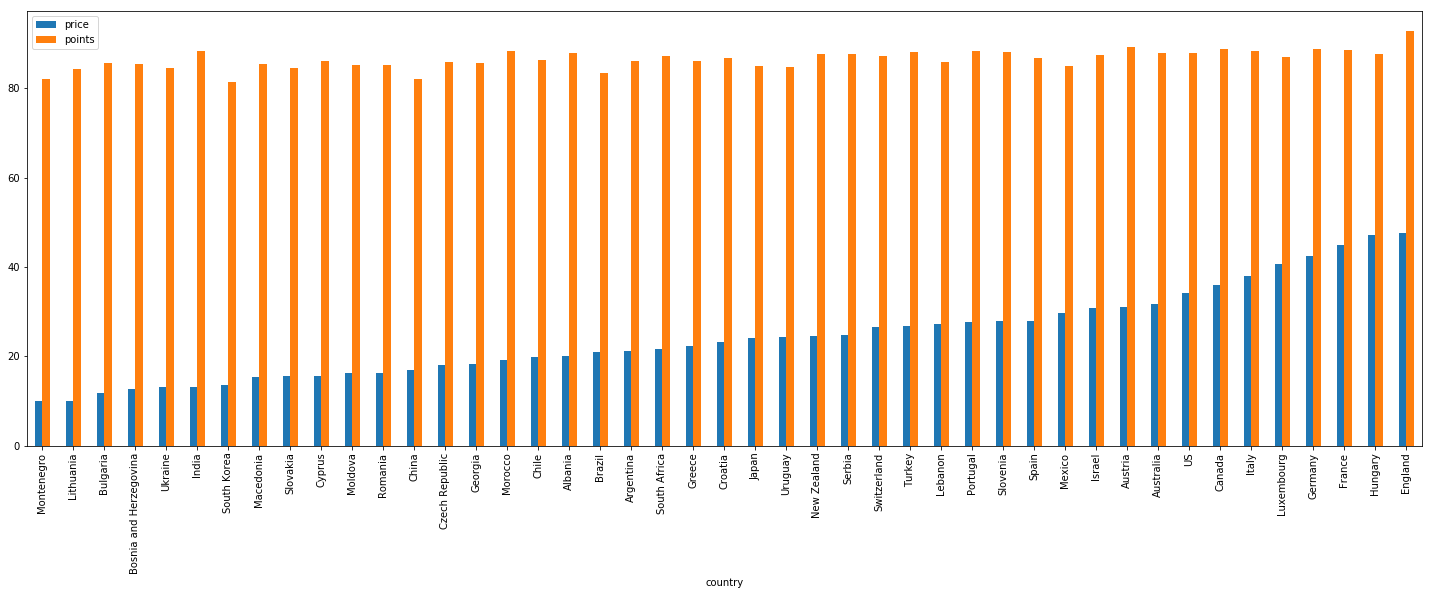

In [31]:
#Groupby country and see breakdown of price and points for all countries in dataset
countrydf = wine.groupby('country').mean().reset_index()
countrydf.sort_values(by = 'price', inplace = True)
countrydf.plot(x = 'country', y = ['price', 'points'], kind = "bar", figsize = (25,8))

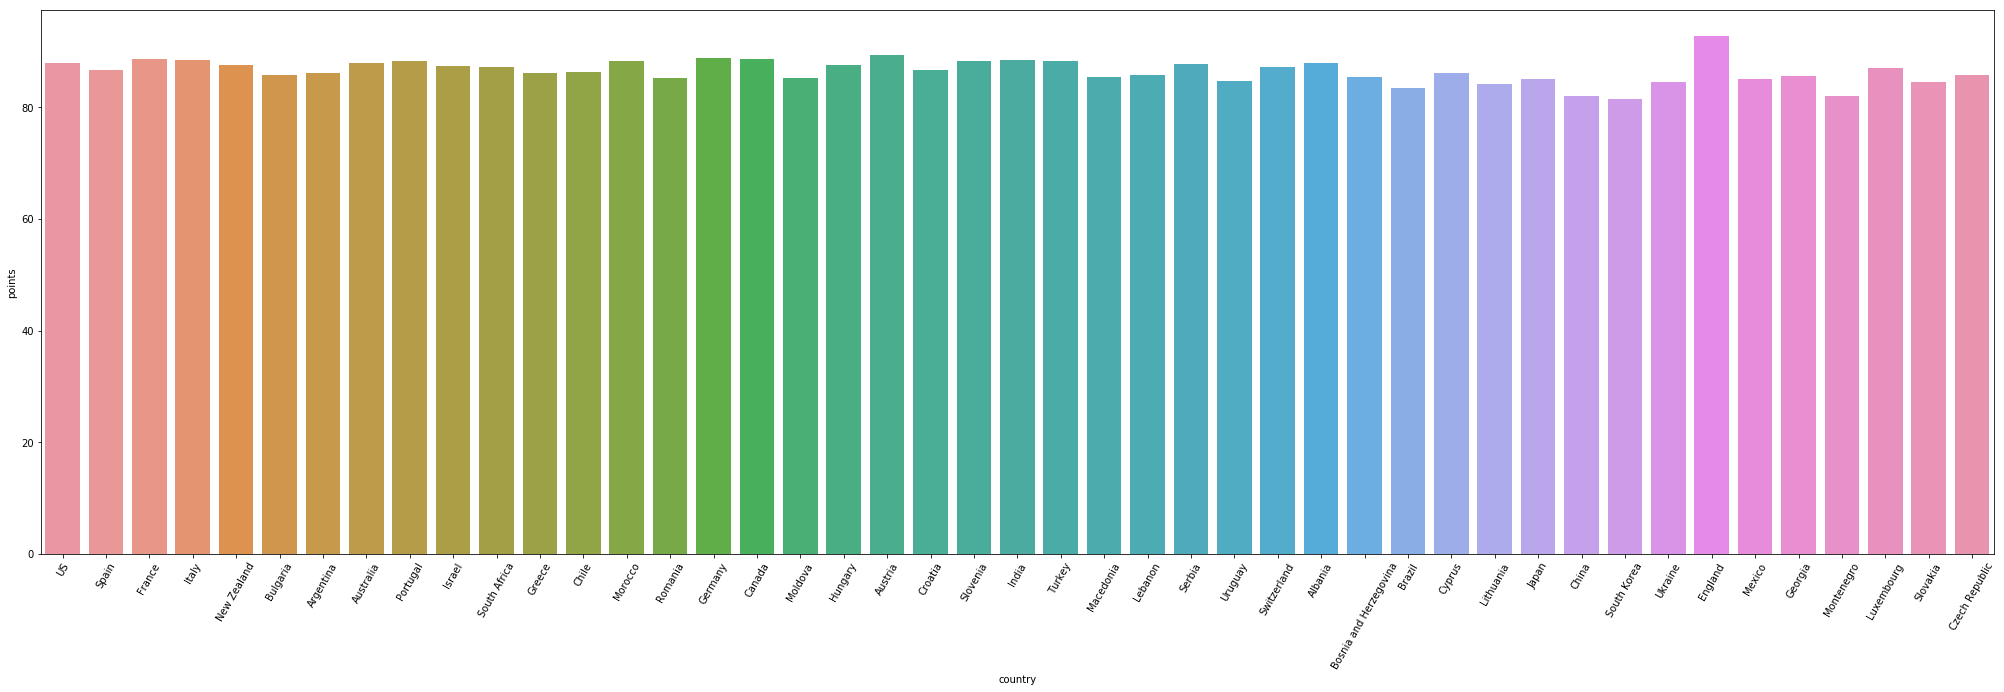

In [32]:
#points by country chart in seaborn
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(35,10))
chart = sns.barplot(wine.country, wine.points.sort_values(ascending = False), orient = 'v', ci = None)
chart.set_xticklabels(chart.get_xticklabels(), rotation=60)
chart

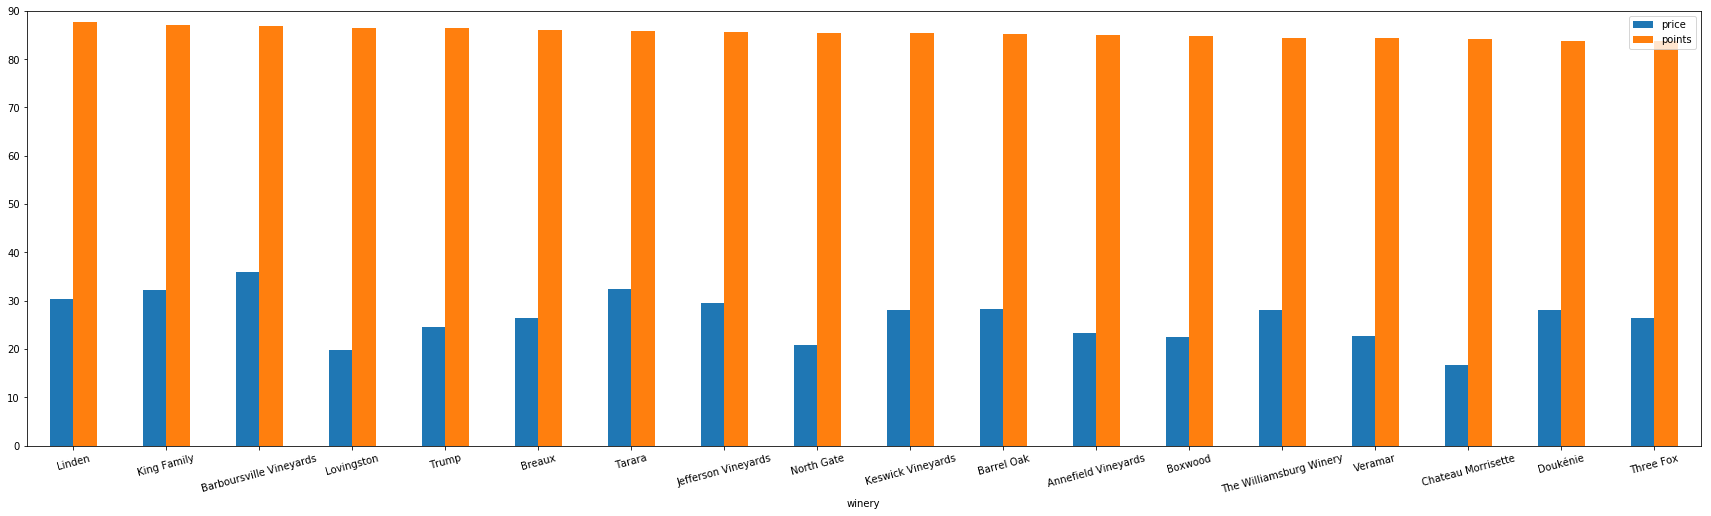

In [33]:
#Look at top wineries in Virgina
vawines = (wine[wine['province']== 'Virginia'])
vawines = vawines[vawines.winery.isin(list(vawines.winery.value_counts()[(vawines.winery.value_counts()>= 8)].keys()))]
vagrouped = vawines.groupby('winery').mean().reset_index()[['winery', 'price', 'points']].sort_values(by = 'points', ascending = False)[0:30]
vagrouped.plot(x = 'winery', y = ['price', 'points'], kind = 'bar', figsize = (30, 8), rot = 15, ylim = (0,90))

In [34]:
# highpriced = wine[wine.region_1=='Napa Valley'].sort_values(by = 'price', ascending = False)[0:500]
highpriced = wine.sort_values(by = 'price', ascending = False)[0:100]
highpriced = highpriced[highpriced.variety.isin(list(highpriced.variety.value_counts()[(highpriced.variety.value_counts()>= 5)].keys()))]

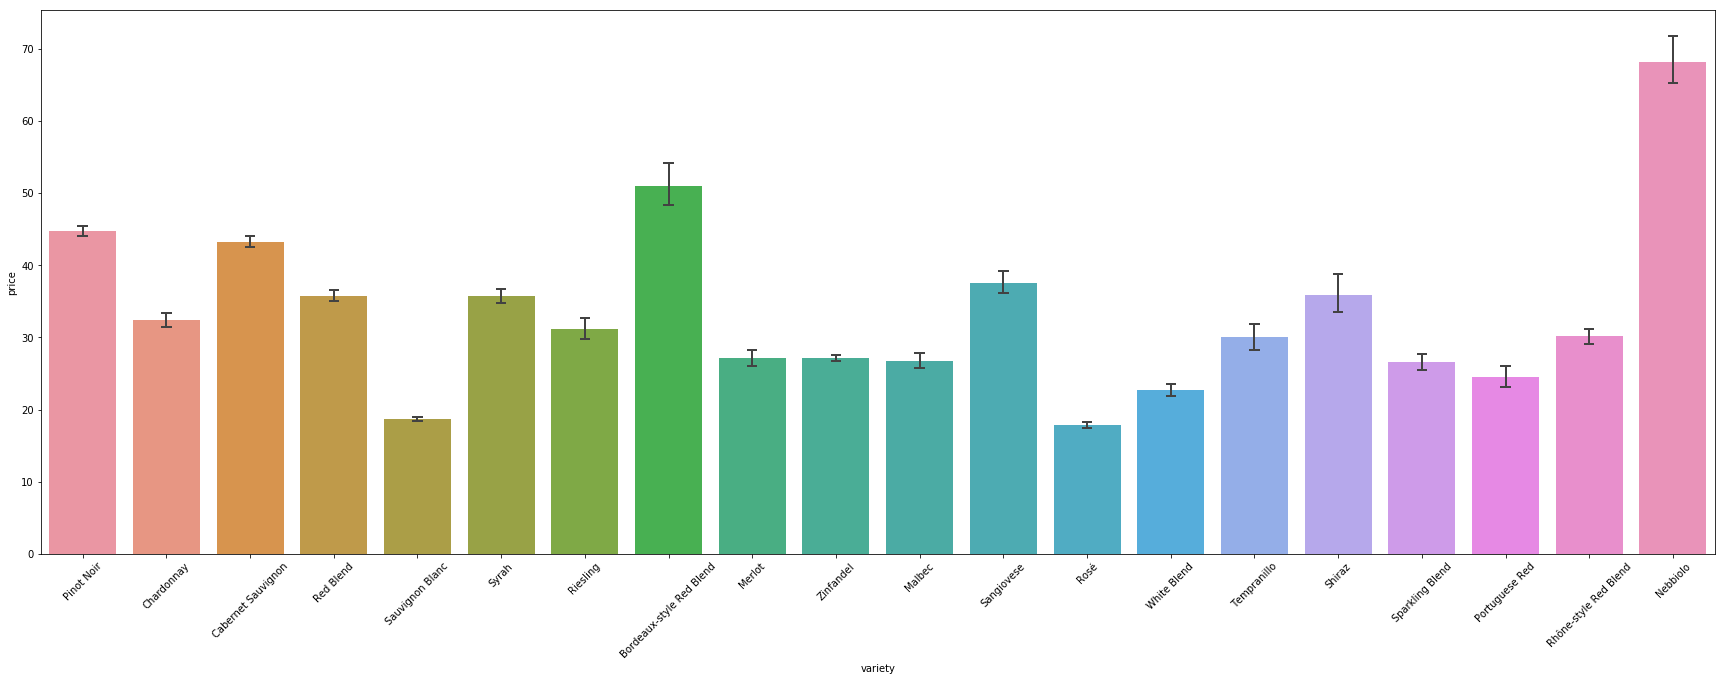

In [35]:
#bar plot of wine varieties that show up at least 2500 times in data set
commonVarieties = wine[wine.variety.isin(list(wine.variety.value_counts().keys()[0:20]))]
plt.figure(figsize = (30,10))
comVarPricePlot = sns.barplot(x = commonVarieties.variety, y = commonVarieties.price, errwidth= 2, capsize = 0.1, order = list(commonVarieties['variety'].value_counts().keys()))
comVarPricePlot.set_xticklabels(comVarPricePlot.get_xticklabels(), rotation=45)
comVarPricePlot

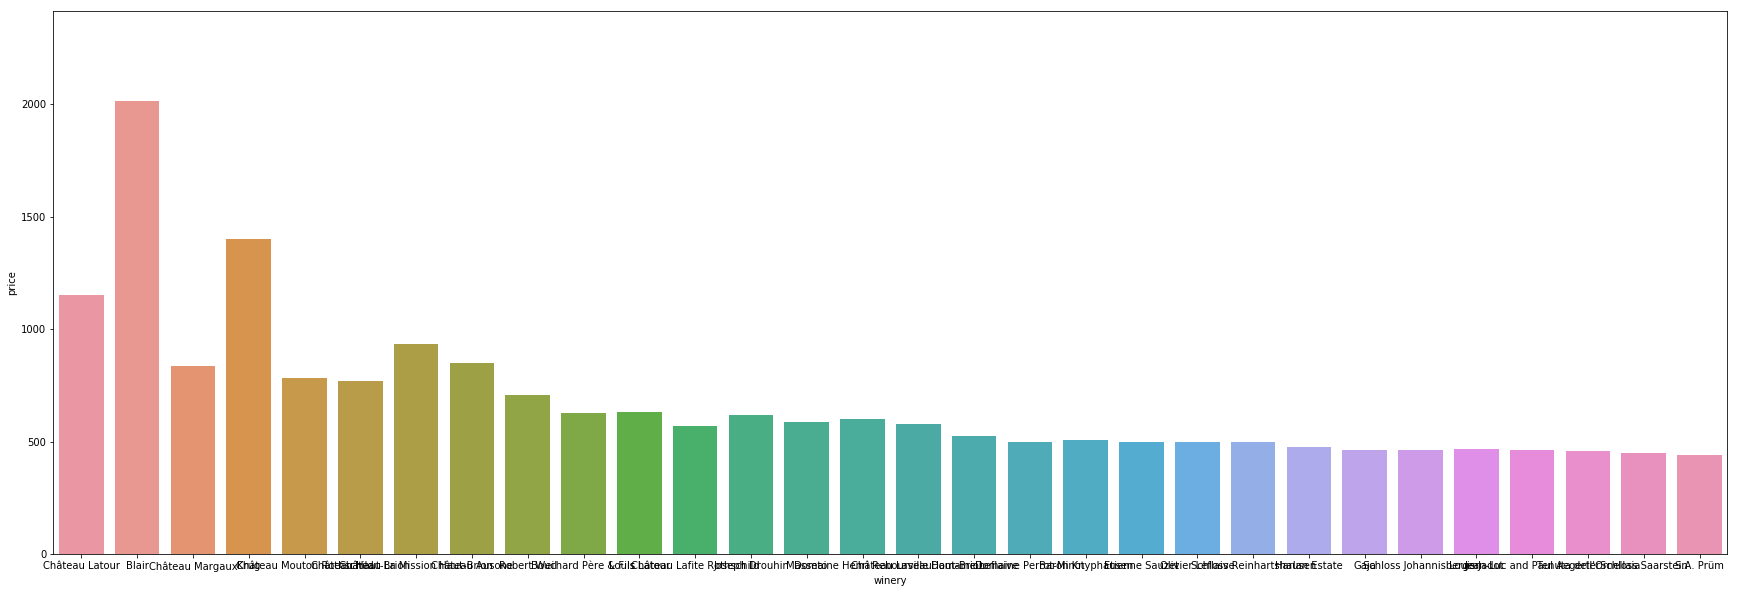

In [36]:
#Average price by variety of 100 highest priced wines
plt.figure(figsize = (30,10))
sns.barplot(x = highpriced.winery, y = highpriced.price, errwidth = 0)
# sns.swarmplot(x = highpriced.winery, y = highpriced.price, color ='0.33')

<Figure size 1800x576 with 0 Axes>

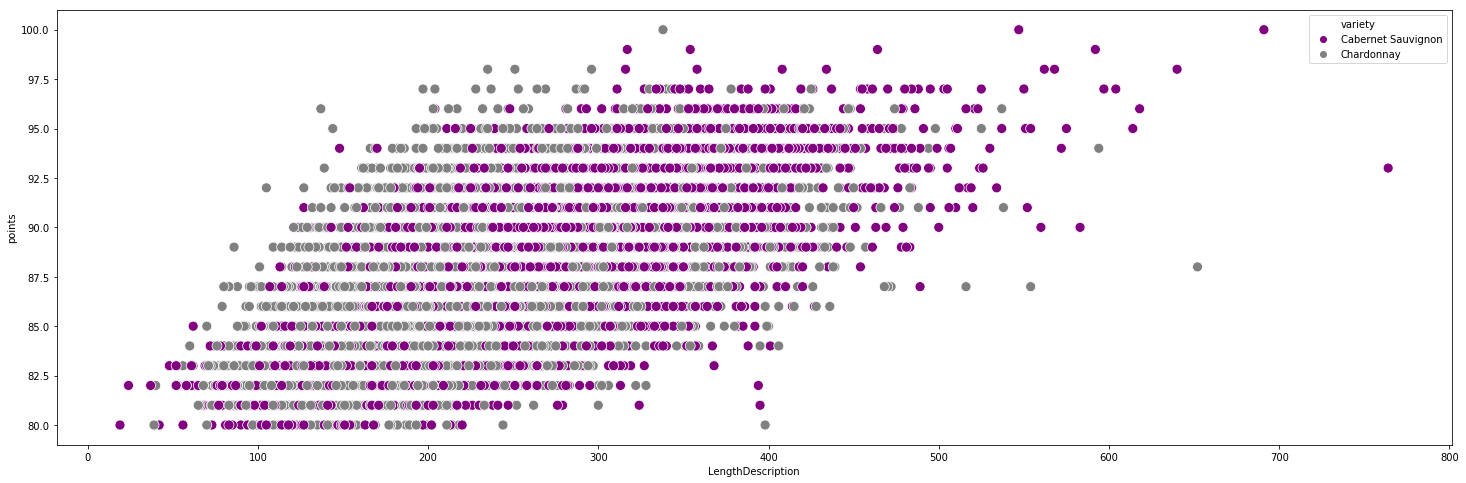

In [37]:
TopFewVarieties = wine[wine.variety.isin(list(['Cabernet Sauvignon', 'Chardonnay']))]
plt.figure(figsize = (25, 8))
cmap = sns.cubehelix_palette(dark=.7, light=.5, as_cmap=True)
colors = ["purple", "gray", "pink"]
# colors = ["#FF0B04", "#4374B3"]
# colorplot = sns.palplot(sns.xkcd_palette(colors))
plt.figure(figsize = (25, 8))
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(x ='LengthDescription', y = 'points', hue = 'variety', data = TopFewVarieties, s = 100)

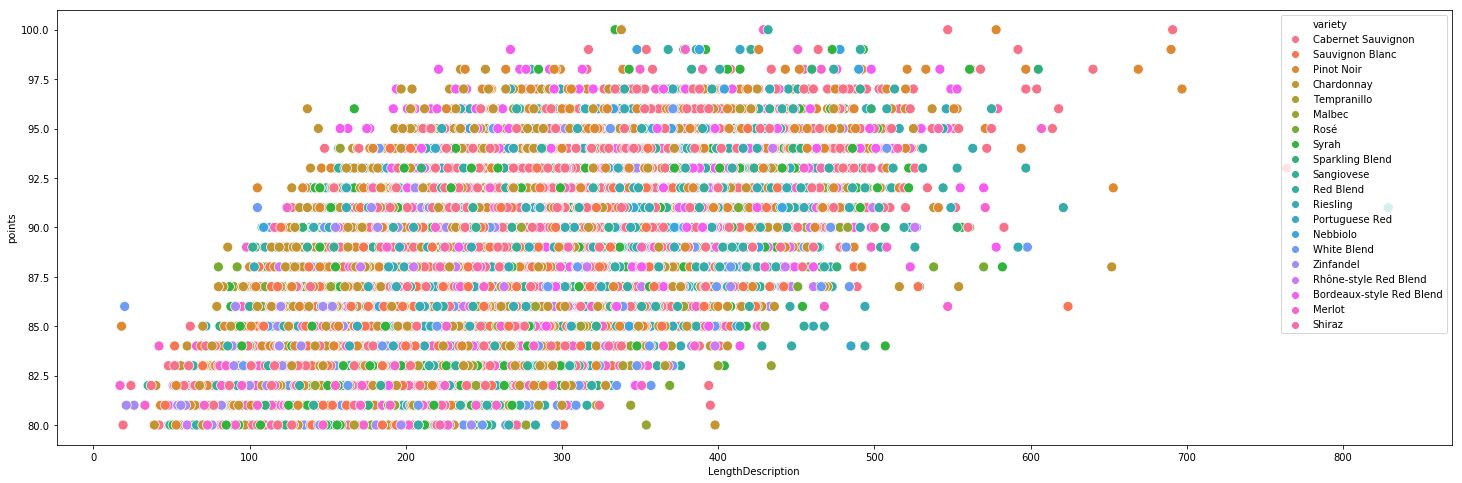

In [38]:
#Scatter plot showing points over length of description and colored by variety
plt.figure(figsize = (25, 8))
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
sns.scatterplot(x ='LengthDescription', y = 'points', hue = 'variety', data = commonVarieties, s = 100)

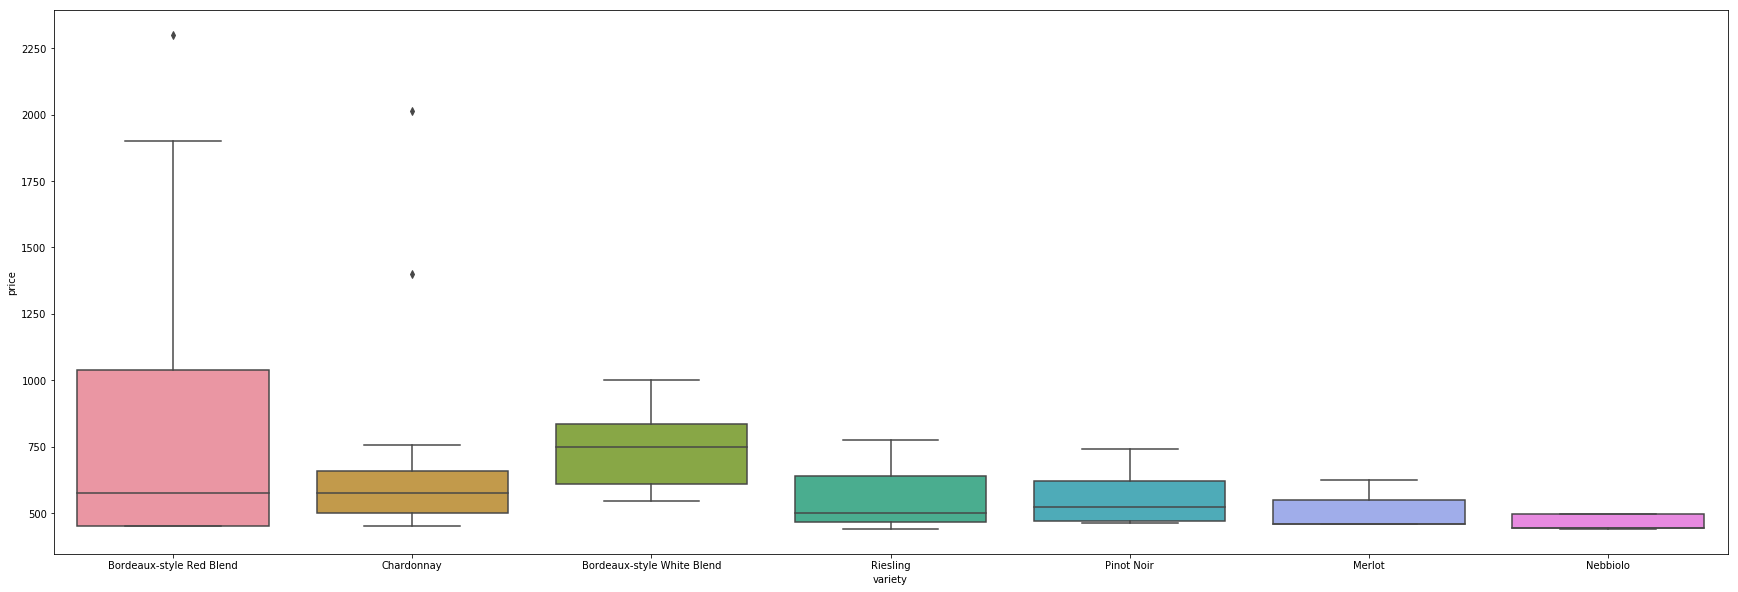

In [39]:
#box plot looking at most expensive wine varieties
plt.figure(figsize = (30,10))
sns.boxplot(x = "variety", y = "price", data = highpriced)

### See How Unique Values in Categorical vars have changed before encoding

In [40]:
uniqueList2 = []
for c in wine_cats:
    print("{} has {} distinct values, {}% of values unique".format(c, len(wine[c].value_counts()), np.around(len(wine[c].value_counts())/wine.shape[0]*100,2)))
    uniqueList2.append(np.around(len(wine[c].value_counts())/wine.shape[0]*100,2))

country has 45 distinct values, 0.05% of values unique
description has 89104 distinct values, 99.98% of values unique
designation has 28342 distinct values, 31.8% of values unique
province has 445 distinct values, 0.5% of values unique
region_1 has 1197 distinct values, 1.34% of values unique
region_2 has 18 distinct values, 0.02% of values unique
variety has 619 distinct values, 0.69% of values unique
winery has 13850 distinct values, 15.54% of values unique
region_1_imputed has 1198 distinct values, 1.34% of values unique


In [41]:
from matplotlib import pyplot as plt
import numpy as np

_uni_country = np.array([uniqueList2[0], 100- uniqueList2[0]])
_uni_description = np.array([uniqueList2[1], 100- uniqueList2[1]])

_uni_designation = np.array([uniqueList2[2], 100- uniqueList2[2]])
_uni_province = np.array([uniqueList2[3], 100- uniqueList2[3]])

_uni_region_1 = np.array([uniqueList2[4], 100- uniqueList2[4]])
_uni_region_2 = np.array([uniqueList2[5], 100- uniqueList2[5]])

_uni_variety = np.array([uniqueList2[6], 100- uniqueList2[6]])
_uni_winery = np.array([uniqueList2[7], 100- uniqueList2[7]])

uni_pairs_list2 = [_uni_country, _uni_description, _uni_designation, _uni_province, _uni_region_1, _uni_region_2, _uni_variety, _uni_winery]

labels = ('Unique', 'Non-Unique')
colors = ['orange', 'red']

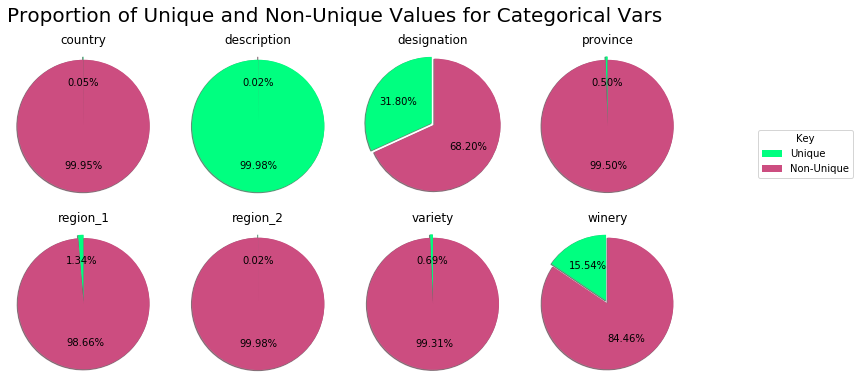

In [42]:
fig, axes= plt.subplots(2, 4)
fig.set_size_inches(12,6)
fig.suptitle("Proportion of Unique and Non-Unique Values for Categorical Vars", fontsize=20)
for i, ax in enumerate(axes.flatten()):
    ax.pie(uni_pairs_list2[i], autopct="%.2f%%", explode = (0,0.1), pctdistance=0.6, shadow = True, radius = 2,startangle=90, colors = [[0,1, 0.5], [0.8, 0.3, 0.5]])
    ax.set_title(wine_cats[i])
    ax.axis('equal')
    
ax.legend(labels,
          title="Key",
          loc="center left",
          bbox_to_anchor=(1.5, 1, 0, 1))
plt.show()

## To handle categorical vars with high number of levels, we will attempt to cast all levels outside the most frequently occuring columns making up 95% of all levels to 'other' 

In [43]:
#First variable is variety, create a dataframe with proportion of population each level represents than create cumulative 'cdf' column to track when 95% of column is represented

varietycdf = pd.DataFrame(wine.variety.value_counts()/(wine.shape[0]-wine.variety.isna().sum())).reset_index()
varietycdf['cdf'] = varietycdf.variety.cumsum()
varietycdf.rename({ 'variety': 'pdf', 'index': 'variety'}, axis = 1, inplace = True)

In [44]:
varietycdf.head()

,variety,pdf,cdf
0,Pinot Noir,0.098756,0.098756
1,Chardonnay,0.097611,0.196367
2,Cabernet Sauvignon,0.091821,0.288188
3,Red Blend,0.068156,0.356344
4,Sauvignon Blanc,0.043459,0.399803


In [45]:
#We can see here that the 98 most popular wine varieties make up 95% of all wine varieties in our data set
len(varietycdf[varietycdf.cdf<0.95])

98

In [46]:
#Take all the variety values that make up the 95% and write them to a list to be filtered on later
keep_variety = varietycdf[varietycdf.cdf < 0.95]['variety'].values

In [47]:
#repeat process for region
region1cdf = pd.DataFrame(wine.region_1.value_counts()/(wine.region_1.shape[0] -wine.region_1.isna().sum())).reset_index()
region1cdf.rename({ 'region_1': 'pdf', 'index': 'region1'}, axis = 1, inplace = True)
region1cdf['cdf'] = region1cdf.pdf.cumsum()

In [48]:
len(region1cdf[region1cdf.cdf < 0.95])

429

In [49]:
#repeat process for imputed region
region1imputedcdf = pd.DataFrame(wine.region_1_imputed.value_counts()/(wine.region_1_imputed.shape[0] -wine.region_1_imputed.isna().sum())).reset_index()
region1imputedcdf.rename({ 'region_1_imputed': 'pdf', 'index': 'region_1_imputed'}, axis = 1, inplace = True)
region1imputedcdf['cdf'] = region1imputedcdf.pdf.cumsum()

In [50]:
len(region1imputedcdf[region1imputedcdf.cdf<.95])

391

In [51]:
#keep first 100 values for region1imputed
keep_region_imputed = region1imputedcdf[0:100].region_1_imputed

In [52]:
provincecdf = pd.DataFrame(wine.province.value_counts()/(wine.province.shape[0] -wine.province.isna().sum())).reset_index()
provincecdf.rename({ 'province': 'pdf', 'index': 'province'}, axis = 1, inplace = True)
provincecdf['cdf'] = provincecdf.pdf.cumsum()

In [53]:
len(provincecdf[provincecdf.cdf < 0.95])

72

In [54]:
keep_province = provincecdf[provincecdf.cdf < 0.95].province.values

In [55]:
winerycdf = pd.DataFrame(wine.winery.value_counts()/(wine.winery.shape[0] -wine.winery.isna().sum())).reset_index()
winerycdf.rename({ 'winery': 'pdf', 'index': 'region1'}, axis = 1, inplace = True)
winerycdf['cdf'] = winerycdf.pdf.cumsum()

In [56]:
len(winerycdf[winerycdf.cdf < 0.95])

9493

In [57]:
# replaceList = wine[~wine.variety.isin(keep_variety)]['variety'].apply(lambda x: x.replace(x, 'other'))

In [58]:
#Replace values in each column being altered by assigning values outside of the keep list to 'other'
wine['variety'].loc[~wine.variety.isin(keep_variety)] = 'other'
wine['province'].loc[~wine.province.isin(keep_province)] = 'other'
wine['region_1_imputed'].loc[~wine.region_1.isin(keep_region_imputed)] = 'other'

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


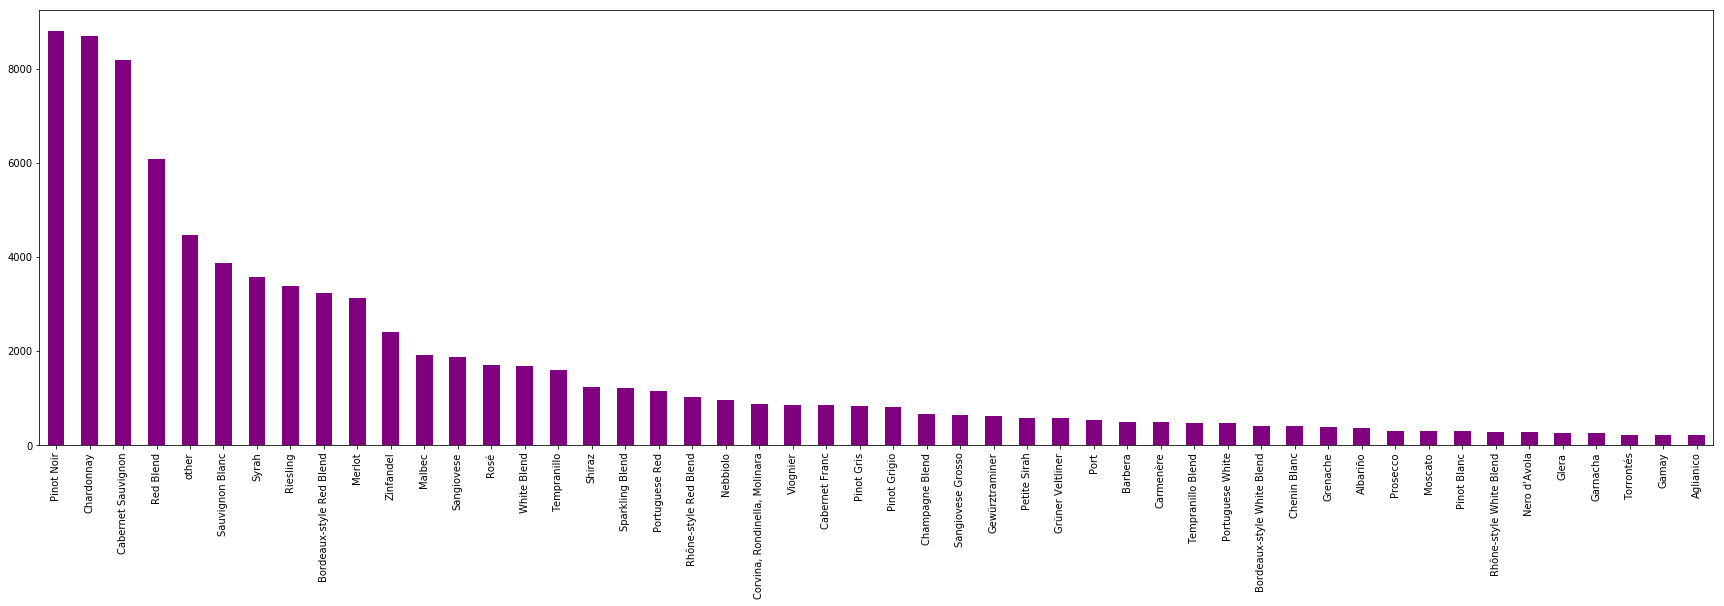

In [59]:
#variety hist after dimensionality reduction
wine.variety.value_counts()[0:50].plot(kind = 'bar', figsize = (30,8))

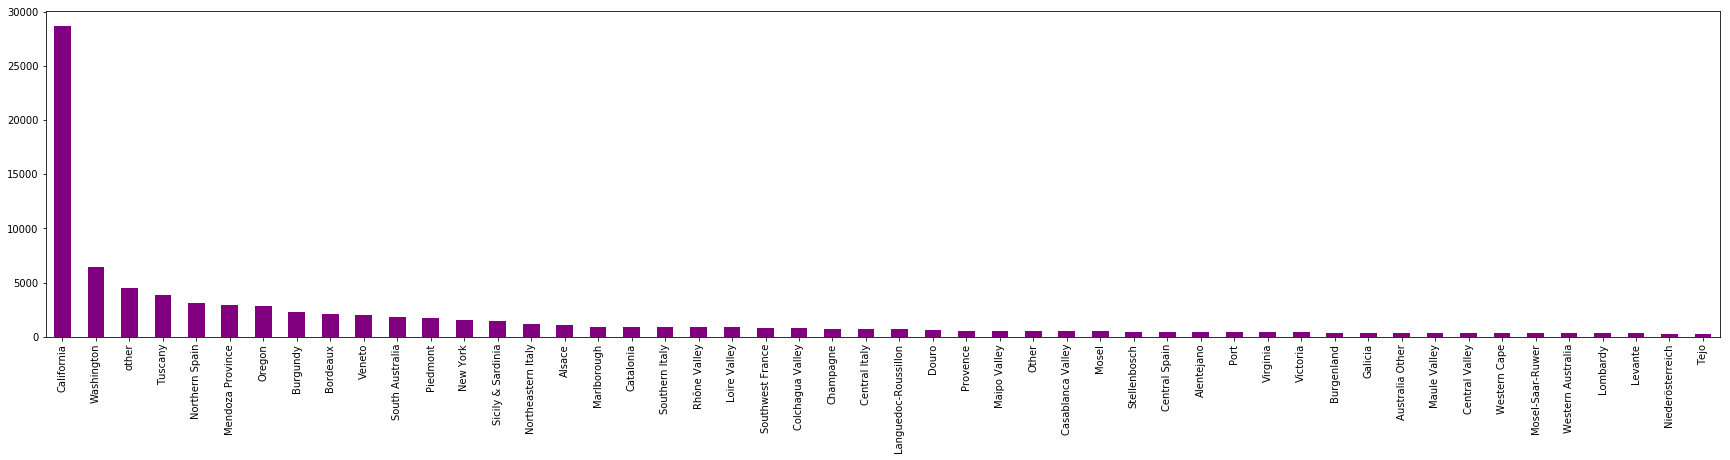

In [60]:
#province hist
wine.province.value_counts()[0:50].plot(kind = 'bar', figsize = (30,6))

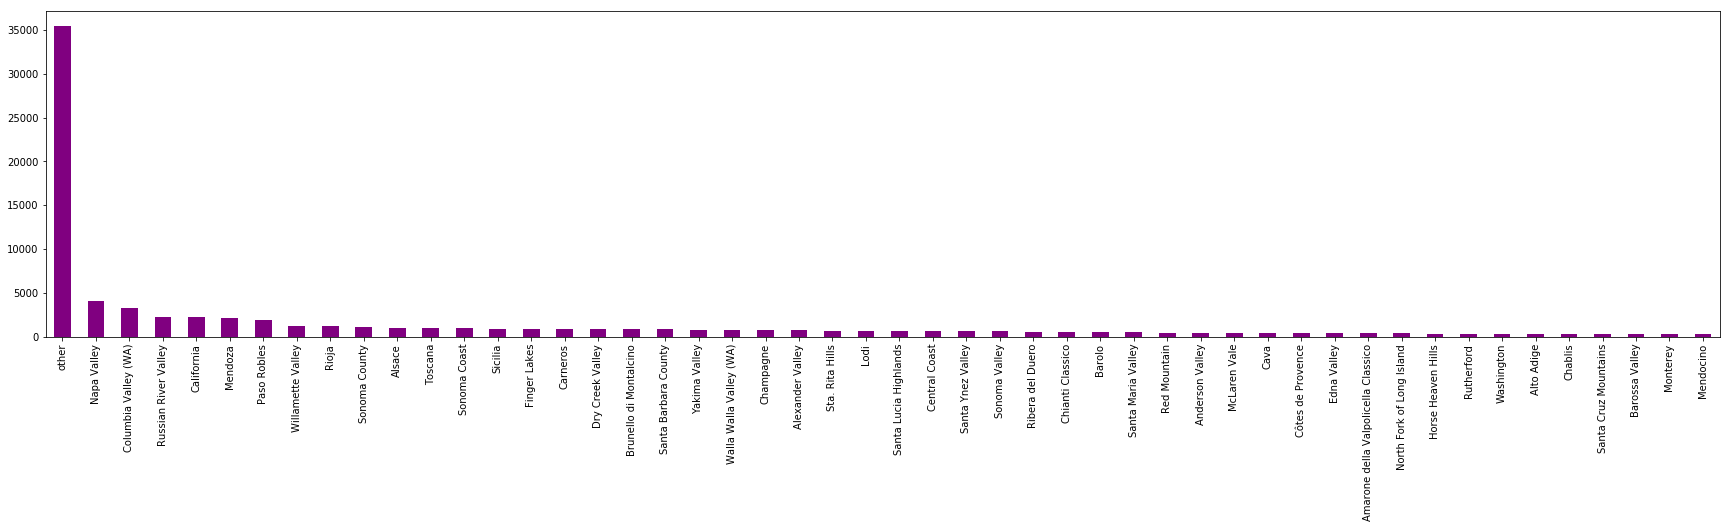

In [61]:
#region 1 imputed hist
wine.region_1_imputed.value_counts()[0:50].plot(kind = 'bar', figsize = (30,6))

In [62]:
#One hot encode all the variables we elected to encode
wine_varietyhots = pd.get_dummies(wine.variety, drop_first=True, prefix = 'var')
wine_provincehots = pd.get_dummies(wine.province, drop_first = True, prefix = 'prov')
wine_countryhots = pd.get_dummies(wine.country, drop_first = True, prefix = 'cntry')
wine_regionhots = pd.get_dummies(wine.region_1_imputed, drop_first = True, prefix = 'reg')

In [63]:
#Index winery
wine_wineryindexed = pd.Series(wine.winery.astype('category').values.codes)

In [64]:
#Drop some columns we're not using
wine.drop('pointsString', axis =1, inplace= True)
wine.drop('index', axis =1, inplace = True)
wine.drop('price', axis =1, inplace = True)

In [65]:
#Add one hot encoded and indexed columns to original dataset
wine_v = pd.concat([wine.drop('variety', axis =1),wine_varietyhots], axis = 1)
wine_v_p = pd.concat([wine_v.drop('province', axis =1), wine_provincehots], axis =1 )
wine_v_p_c = pd.concat([wine_v_p.drop('country', axis =1), wine_countryhots], axis = 1)
wine_v_p_c_r = pd.concat([wine_v_p_c.drop('region_1_imputed', axis =1), wine_regionhots], axis = 1)
wine_v_p_c_r_w = pd.concat([wine_v_p_c_r.drop('winery', axis =1), wine_wineryindexed], axis = 1)
wine_v_p_c_r_w.rename({0: 'winery_indexed'}, axis =1, inplace = True)

In [66]:
#Form feature df and label vector (for feature df drop all the columns we're not going to use in prediction)
X = wine_v_p_c_r_w.drop(['points', 'description', 'region_1','designation', 'region_2'], axis =1)
Y = wine_v_p_c_r_w['points']

In [67]:
#partition data into training and testing split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.30, random_state = 212)

In [68]:
#Try basic linear regression first
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train, Y_train)
yhat = lm.predict(X_test)

In [69]:
from sklearn.metrics import r2_score, mean_squared_error
print("R^2 Score: ", np.around(r2_score(Y_test,yhat),3))
print("MSE: ", np.around(mean_squared_error(Y_test, yhat),3))

R^2 Score:  0.58
MSE:  4.354


In [70]:
#Try a gradient boosting model next
from sklearn import ensemble

gbreg = ensemble.GradientBoostingRegressor()
gbreg.fit(X_train, Y_train)

yhat_gb = gbreg.predict(X_test)

In [71]:
print("R^2 Score: ", np.around(r2_score(Y_test,yhat_gb),3))
print("MSE: ", np.around(mean_squared_error(Y_test, yhat_gb),3))

R^2 Score:  0.587
MSE:  4.29


## Bring in the NLP API's!

In [72]:
# The code was removed by Watson Studio for sharing.

In [73]:
#install Watson Library
!pip install ibm_watson

     |████████████████████████████████| 378kB 7.6MB/s eta 0:00:01
     |████████████████████████████████| 204kB 27.9MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/71/9a/0a/9b3ca8eca69bc5362eb04709a750b30055a9d27818fd0c9494
  Stored in directory: /home/dsxuser/.cache/pip/wheels/6a/42/50/f96888116b329578304f9dda4693cef6f3e76e18272d22cb6c
Successfully built ibm-watson ibm-cloud-sdk-core


In [74]:
#import libraries and test using sample code

import json
from ibm_watson import NaturalLanguageUnderstandingV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from ibm_watson.natural_language_understanding_v1 import Features, EntitiesOptions, KeywordsOptions, EmotionOptions, SentimentOptions

authenticator = IAMAuthenticator(nlu_creds['apikey'])
natural_language_understanding = NaturalLanguageUnderstandingV1(
    version='2019-07-12',
    authenticator=authenticator)

natural_language_understanding.set_service_url(nlu_creds['url'])

response = natural_language_understanding.analyze(
    text='IBM is an American multinational technology company '
    'headquartered in Armonk, New York, United States, '
    'with operations in over 170 countries.',
    features=Features(
        entities=EntitiesOptions(emotion=True, sentiment=True, limit=2),
        keywords=KeywordsOptions(emotion=True, sentiment=True,
                                 limit=2))).get_result()

print(json.dumps(response, indent=2))

{
  "usage": {
    "text_units": 1,
    "text_characters": 140,
    "features": 2
  },
  "language": "en",
  "keywords": [
    {
      "text": "American multinational technology company",
      "sentiment": {
        "score": 0,
        "label": "neutral"
      },
      "relevance": 0.984693,
      "emotion": {
        "sadness": 0.082208,
        "joy": 0.074673,
        "fear": 0.050149,
        "disgust": 0.035402,
        "anger": 0.024366
      },
      "count": 1
    },
    {
      "text": "United States",
      "sentiment": {
        "score": 0,
        "label": "neutral"
      },
      "relevance": 0.854311,
      "emotion": {
        "sadness": 0.082208,
        "joy": 0.074673,
        "fear": 0.050149,
        "disgust": 0.035402,
        "anger": 0.024366
      },
      "count": 1
    }
  ],
  "entities": [
    {
      "type": "Company",
      "text": "IBM",
      "sentiment": {
        "score": 0,
        "label": "neutral"
      },
      "relevance": 0.95577,
      "emoti

In [75]:
#Try out setting some options and calling api against a random description in the dataset

options = Features(
        emotion=EmotionOptions(),
        sentiment = SentimentOptions(),
        keywords=KeywordsOptions(emotion=True, sentiment=True,
                                 limit=2))

response = natural_language_understanding.analyze(
    text=wine.description[4097],
    features=options).get_result()

response

{'usage': {'text_units': 1, 'text_characters': 176, 'features': 3},
 'sentiment': {'document': {'score': 0.989155, 'label': 'positive'}},
 'language': 'en',
 'keywords': [{'text': 'ripe strawberry flavors',
   'sentiment': {'score': 0.975964, 'label': 'positive'},
   'relevance': 0.819596,
   'emotion': {'sadness': 0.023433,
    'joy': 0.821799,
    'fear': 0.024255,
    'disgust': 0.062765,
    'anger': 0.021691},
   'count': 1},
  {'text': 'rounded feel',
   'sentiment': {'score': 0.831786, 'label': 'positive'},
   'relevance': 0.66597,
   'emotion': {'sadness': 0.423519,
    'joy': 0.234841,
    'fear': 0.092574,
    'disgust': 0.258604,
    'anger': 0.079144},
   'count': 1}],
 'emotion': {'document': {'emotion': {'sadness': 0.067428,
    'joy': 0.767481,
    'fear': 0.027653,
    'disgust': 0.128456,
    'anger': 0.024901}}}}

In [76]:
#Create functions for returning specific components of API call response 
def getKeyword1(text1):
    response = natural_language_understanding.analyze(
    text=text1,
    features=Features(keywords=KeywordsOptions(emotion=True, sentiment=True, limit=2)),
    language = 'en').get_result()
    return response['keywords'][0]['text']

def getKeyword2(text1):
    response = natural_language_understanding.analyze(
    text=text1,
    features=Keyword_options,
    language = 'en').get_result()
    return response['keywords'][1]['text']

def getEmotion(text1):
    response = natural_language_understanding.analyze(
    text=text1,
    features = Features(emotion=EmotionOptions()),
    language='en').get_result()
    return response['emotion']['document']['emotion']

In [77]:
wine.description[3401]

'The 2012 vintage brings rich fruit flavors to this estate bottling, with a core of cherries and streaks of kale and espresso. The tannins are ripe and sufficient, though the herbal elements may soften a bit with further bottle age.'

In [78]:
getEmotion(wine.description[3401])

{'sadness': 0.044427,
 'joy': 0.725587,
 'fear': 0.068698,
 'disgust': 0.048386,
 'anger': 0.058092}

In [79]:
#import libraries to use progress_apply to see lambda function progress and define helper function to run getJoy()
from tqdm import tqdm
tqdm.pandas()

def RunGetEmotion(df):
    df['Emotion'] = df['description'].progress_apply(lambda row: getEmotion(row))
    return df

In [80]:
import time
import multiprocessing
from multiprocessing import Pool

#Define function to parallelize lambda function calls
def parallelized_func_call(df, func, n_cores):
    start = time.time()
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    print('Duration: {} seconds'.format(np.around(time.time() - start, 2)))
    return df

In [81]:
#see how many CPUs are available to use
print("Available CPUs:", multiprocessing.cpu_count())

Available CPUs: 56


In [82]:
wine_sample = wine[0:200]

In [83]:
start = time.time()

# joyColumn = wine_sample['description'].progress_apply(lambda row: getJoy(row))
wine_sample_result_a = RunGetEmotion(wine_sample)
print('Duration: {} seconds'.format(np.around(time.time() - start), 2))

100%|██████████| 200/200 [01:00<00:00,  2.65it/s]

Duration: 61.0 seconds



/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [84]:
wine_sample_result_b = parallelized_func_call(wine_sample, RunGetEmotion, n_cores = 30)

100%|██████████| 7/7 [00:03<00:00,  2.11it/s]

100%|██████████| 7/7 [00:03<00:00,  2.21it/s]

100%|██████████| 7/7 [00:03<00:00,  2.08it/s]






100%|██████████| 7/7 [00:03<00:00,  1.48it/s]

100%|██████████| 7/7 [00:03<00:00,  2.53it/s]











Duration: 5.52 seconds


In [85]:
#Parse out all the different emotions
wine_sample_result_b['sadness'] = wine_sample_result_b['Emotion'].apply(lambda row: row['sadness'])
wine_sample_result_b['joy'] = wine_sample_result_b['Emotion'].apply(lambda row: row['joy'])
wine_sample_result_b['fear'] = wine_sample_result_b['Emotion'].apply(lambda row: row['fear'])
wine_sample_result_b['disgust'] = wine_sample_result_b['Emotion'].apply(lambda row: row['disgust'])
wine_sample_result_b['anger'] = wine_sample_result_b['Emotion'].apply(lambda row: row['anger'])

In [86]:
#Check to see sample of Emotion column and parsed columns
wine_sample_result_b.iloc[0:5, -6:]

,Emotion,sadness,joy,fear,disgust,anger
0,"{'sadness': 0.027412, 'joy': 0.901618, 'fear':...",0.027412,0.901618,0.019897,0.019165,0.028484
1,"{'sadness': 0.075859, 'joy': 0.750786, 'fear':...",0.075859,0.750786,0.036732,0.048867,0.076539
2,"{'sadness': 0.030686, 'joy': 0.884747, 'fear':...",0.030686,0.884747,0.024251,0.013384,0.019040
3,"{'sadness': 0.137036, 'joy': 0.722419, 'fear':...",0.137036,0.722419,0.105437,0.022763,0.046443
4,"{'sadness': 0.079101, 'joy': 0.821667, 'fear':...",0.079101,0.821667,0.015322,0.028469,0.071774


In [ ]:
## ONLY RUN IF NEED TO RECOMUPUTE EMOTION COLUMN - Otherwise retrieve previously computed joy data from s3 bucket in next cell

# wine_emotion = parallelized_func_call(wine_v_p_c_r_w[['description', 'points']], RunGetEmotion, n_cores = 30)

## ONLY RUN 

# from io import StringIO 
# import boto3

# csv_buffer1 = StringIO()
# wine_emotion.to_csv(csv_buffer1)
# s3_resource = boto3.resource('s3', aws_access_key_id=s3_access_key,aws_secret_access_key=s3_secret_key)
# s3_resource.Object('edb-demos', 'wineWithEmotion.csv').put(Body=csv_buffer1.getvalue())

In [89]:
s3 = boto3.client('s3', aws_access_key_id=s3_access_key,aws_secret_access_key=s3_secret_key)
wine_joy_obj = s3.get_object(Bucket='edb-demos', Key='wineWithEmotion.csv')

wine_emotion_s3 = pd.read_csv(io.BytesIO(wine_joy_obj['Body'].read()))
wine_emotion_s3.head()

,Unnamed: 0,description,points,Emotion
0,0,This tremendous 100% varietal wine hails from ...,96,"{'sadness': 0.027412, 'joy': 0.901618, 'fear':..."
1,1,"Ripe aromas of fig, blackberry and cassis are ...",96,"{'sadness': 0.075859, 'joy': 0.750786, 'fear':..."
2,2,Mac Watson honors the memory of a wine once ma...,96,"{'sadness': 0.030686, 'joy': 0.884747, 'fear':..."
3,3,"This spent 20 months in 30% new French oak, an...",96,"{'sadness': 0.137036, 'joy': 0.722419, 'fear':..."
4,4,"This is the top wine from La Bégude, named aft...",95,"{'sadness': 0.079101, 'joy': 0.821667, 'fear':..."


In [90]:
wineEmotion = pd.concat([wine_v_p_c_r_w, wine_emotion_s3.drop(['points', 'Unnamed: 0'], axis =1)], axis = 1)

In [91]:
#When reading data from S3 - dict gets read in as a string, this cell will replace with an actual dicts 
import json

wineEmotion['Emotion'] = wineEmotion['Emotion'].apply(lambda row: row.replace("'", '"'))
wineEmotion['Emotion'] = wineEmotion['Emotion'].apply(lambda row: json.loads(row))

In [92]:
wineEmotion['sadness'] = wineEmotion['Emotion'].apply(lambda row: row['sadness'])
wineEmotion['joy'] = wineEmotion['Emotion'].apply(lambda row: row['joy'])
wineEmotion['fear'] = wineEmotion['Emotion'].apply(lambda row: row['fear'])
wineEmotion['disgust'] = wineEmotion['Emotion'].apply(lambda row: row['disgust'])
wineEmotion['anger'] = wineEmotion['Emotion'].apply(lambda row: row['anger'])

In [93]:
wineEmotion.shape

(89119, 328)

In [94]:
X1 = wineEmotion.drop(['points', 'description', 'designation', 'region_1', 'region_2', 'Emotion'], axis =1)
Y1 = wineEmotion['points']

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1,Y1, test_size = 0.30, random_state = 212)

lm1 = LinearRegression()
lm1.fit(X_train1, Y_train1)
yhat1 = lm1.predict(X_test1)

print("R^2 Score: ", np.around(r2_score(Y_test1,yhat1),3))
print("MSE: ", np.around(mean_squared_error(Y_test1, yhat1),3))

R^2 Score:  0.601
MSE:  4.146


In [95]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train1.columns
    coefs_df['coefs'] = lm1.coef_
    coefs_df['abs_coefs'] = np.abs(lm1.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm1.coef_, X_train)

#A quick look at the top results

In [96]:
coef_df = coef_weights(lm1.coef_, X_train1).sort_values(by= 'abs_coefs')
coef_df.tail(25)

,est_int,coefs,abs_coefs
26,var_Gamay,2.214106,2.214106
210,cntry_Spain,-2.299656,2.299656
91,var_Turbiana,2.306267,2.306267
168,prov_Washington,2.368533,2.368533
151,prov_Provence,2.396750,2.396750
102,prov_Andalucia,2.442589,2.442589
319,disgust,-2.447748,2.447748
316,sadness,-2.484164,2.484164
146,prov_Oregon,2.493626,2.493626
183,cntry_Czech Republic,-2.861374,2.861374


In [97]:
#Now Gradient boosting model
from sklearn import ensemble

gbreg1 = ensemble.GradientBoostingRegressor()
gbreg1.fit(X_train1, Y_train1)

yhat_gb1 = gbreg1.predict(X_test1)

In [98]:
print("R^2 Score: ", np.around(r2_score(Y_test1,yhat_gb1),3))
print("MSE: ", np.around(mean_squared_error(Y_test1, yhat_gb1),3))

R^2 Score:  0.605
MSE:  4.103


In [99]:
#create array of correlations to see how various factors correlated with points
finalCorrs = wineEmotion.corr()['points'].sort_values(ascending = False)

In [101]:
#look at variables with at least a 7.5% correlation
finalCorrs[abs(finalCorrs)>0.075]

points                        1.000000
logPrice                      0.610913
LengthDescription             0.556318
joy                           0.252966
reg_Brunello di Montalcino    0.098317
prov_Tuscany                  0.096747
var_Pinot Noir                0.096067
prov_Washington               0.087392
prov_Burgundy                 0.085274
cntry_France                  0.085115
var_Sangiovese Grosso         0.077158
var_Nebbiolo                  0.076317
var_Merlot                   -0.081875
cntry_Spain                  -0.087703
reg_Mendoza                  -0.093372
prov_Mendoza Province        -0.095467
cntry_Chile                  -0.102470
cntry_Argentina              -0.110702
fear                         -0.120632
anger                        -0.136229
reg_California               -0.152298
sadness                      -0.152978
disgust                      -0.209621
Name: points, dtype: float64

Text(0, 0.5, 'No. of Occurances')

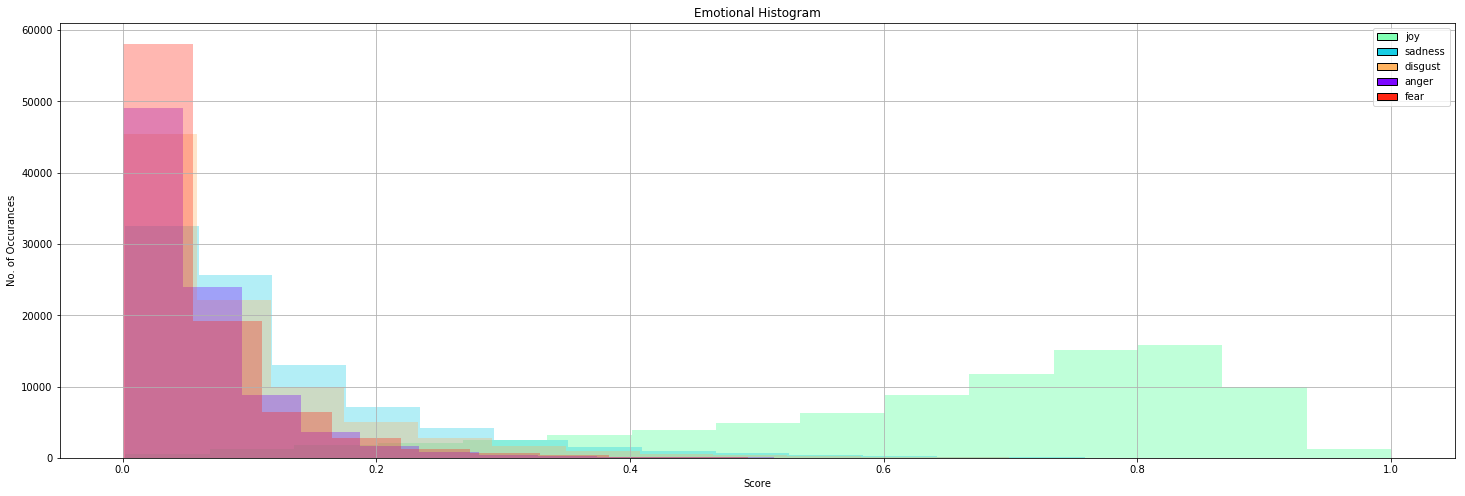

In [102]:
from matplotlib.patches import Rectangle
plt.figure(figsize = (25,8))

cmap = plt.get_cmap('rainbow')
joycolor = cmap(0.5)
sadnesscolor =cmap(.3)
disgustcolor = cmap(0.75)
angercolor = cmap(0.01)
fearcolor = cmap(.95)

joyhist = wineEmotion.joy.hist(alpha = 0.5, color = joycolor, bins = 15)
sadnesshist = wineEmotion.sadness.hist(alpha = 0.33, color = sadnesscolor, bins = 15)
disgusthist = wineEmotion.disgust.hist(alpha = 0.33, color = disgustcolor, bins = 15)
angerhist = wineEmotion.anger.hist(alpha = 0.33, color = angercolor, bins = 15)
fearhist = wineEmotion.fear.hist(alpha = 0.33, color = fearcolor, bins = 15)



handles = [Rectangle((0,0),1,1, color = c, ec="k") for c in [joycolor, sadnesscolor, disgustcolor, angercolor, fearcolor]]
labels= ["joy","sadness", "disgust", "anger", "fear"]
plt.legend(handles, labels)
plt.title(label = 'Emotional Histogram')
plt.xlabel(xlabel = 'Score')
plt.ylabel(ylabel = 'No. of Occurances')

# ax.legend((joyhist, sadnesshist, disgusthist, angerhist, fearhist), labels = ['joy', 'sadness', 'disgust', 'anger', 'fear'])

## Look at keywords in reviews

In [103]:
#create helper function to apply getJoy() function to dataframe

def RunGetKeyword(df):
    df['KeywordColumn'] = df['description'].progress_apply(lambda row: getKeyword1(row))
    return df

In [104]:
#Create a df for cab sav and one chardonnay
cab = wine[wine.variety=='Cabernet Sauvignon'].reset_index().drop('index', axis =1)
chard = wine[wine.variety == 'Chardonnay'].reset_index().drop('index', axis =1)

In [117]:
#Get keywords for all cab sav decriptions
tqdm.pandas()
cabKeys = parallelized_func_call(cab[0:1200], RunGetKeyword, n_cores = 16)


100%|██████████| 75/75 [00:36<00:00,  1.21it/s]

Duration: 38.44 seconds


In [106]:
#Get keywords for all chardonnay descriptions
chardKeys = parallelized_func_call(chard[0:1200], RunGetKeyword, n_cores = 30)


100%|██████████| 75/75 [00:36<00:00,  1.65it/s]

Duration: 38.4 seconds


In [107]:
!pip install WordCloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

     |████████████████████████████████| 368kB 8.4MB/s eta 0:00:01


In [108]:
#update stopwords with wine specific terms to avoid
stopwords = set(STOPWORDS)
stopwords.update(["drink", "now", "wine", "flavor", "flavors", "Chardonnay", "Cabernet", "Cabernet Franc", "aroma", "aromas", "Cabernet Sauvignon"])

In [109]:
#Take cabernet out of wordcloud
filtered_cab_keywords = [word for word in cabKeys.KeywordColumn if word not in stopwords]
CabKeyString = " ".join(key for key in filtered_cab_keywords)
CabKeyString = CabKeyString.replace('Cabernet', '')
CabKeyString = CabKeyString.replace('Sauvignon', '')

In [110]:
#Take 'chardonnay' out of wordcloud
filtered_chard_keywords = [word for word in chardKeys.KeywordColumn if word not in stopwords]
ChardKeyString = " ".join(key for key in filtered_chard_keywords)
ChardKeyString = ChardKeyString.replace('Chardonnay', '')

In [111]:
# Create wordclouds
wordcloudCab = WordCloud(stopwords=stopwords, background_color="black", colormap='jet', max_words=150).generate(CabKeyString)
wordcloudChard = WordCloud(stopwords=stopwords, background_color="white", max_words = 150).generate(ChardKeyString)

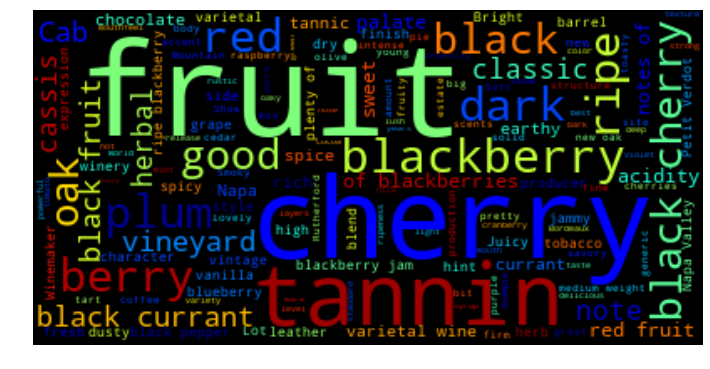

In [112]:
#Show Cab wordcloud
plt.figure(figsize=(12,12))
plt.imshow(wordcloudCab, interpolation='bilinear')
plt.axis("off")
plt.show()

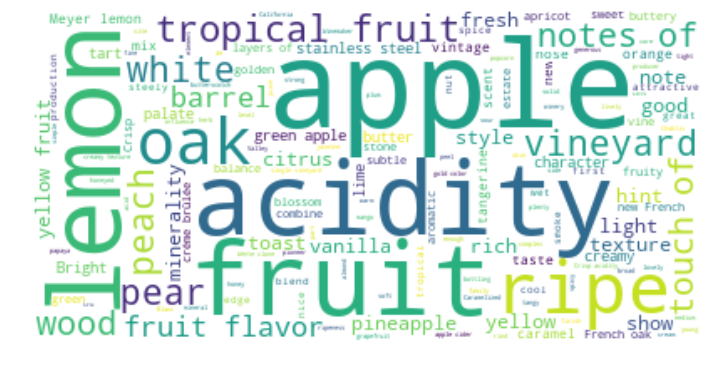

In [113]:
#Show chard wordcloud
plt.figure(figsize=(12,12))
plt.imshow(wordcloudChard, interpolation='bilinear')
plt.axis("off")
plt.show()

## Appendix - Unused Code

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# # >>> X, y = make_regression(n_features=4, n_informative=2,
# # ...                        random_state=0, shuffle=False)
# RFreg = RandomForestRegressor(n_estimators = 50)
# RFreg.fit(X_train, Y_train)
# RandomForestRegressor(...)
# RFyhat = RFreg.predict(X_test)

# print("R^2 Score: ", np.around(r2_score(Y_test,RFyhat),3))
# print("MSE: ", np.around(mean_squared_error(Y_test, RFyhat),3))

# from sklearn.linear_model import LogisticRegression
# lr = LogisticRegression()
# lr.fit(X_train, Y_train)
# yhat_lr = lr.predict(X_test)

# print("R^2 Score: ", np.around(r2_score(Y_test,yhat_lr),3))
# print("MSE: ", np.around(mean_squared_error(Y_test, yhat_lr),3))

In [ ]:
# wine_countryhots = pd.get_dummies(wine.country, drop_first=True)
# wine.join(wine_countryhots).corr()['points'].sort_values(ascending = False)

In [ ]:
# wine.groupby('country').mean()['price'].sort_values(ascending=False)[0:25].plot(kind='bar', figsize = (20,6))
# wine.groupby('country').mean()['points'].sort_values(ascending = False)[0:25].plot(kind='bar')

In [ ]:
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import ColumnTransformer, make_column_transformer
# ohc = OneHotEncoder(handle_unknown='ignore')

# oneHotsList = ['country', 'province', 'variety']

# preprocess = make_column_transformer((oneHotsList, OneHotEncoder()))

# sampy = wine[2410:2510]

# sampyohc = preprocess.fit(sampy)

# sampyTransformed = sampyohc.transform(sampy)

# sampyTransformed.toarray()

In [ ]:
# s3_resource = boto3.resource('s3')
# s3_resource.Object(bucket, 'df.csv').put(Body=csv_buffer.getvalue())

In [ ]:
# #plot average price of 30 most expensive wine varieties that have at least 100 bottles in the dataset

# plt.figure(figsize=(35,10))
# varieties = wine.groupby('variety').mean().sort_values(by = 'price', ascending = False).reset_index()[0:30]
# varieties = varieties[wine.variety.isin(list(wine.variety.value_counts()[wine.variety.value_counts()>=100].keys()))]

# chart = sns.barplot(varieties.variety, varieties.price.sort_values(ascending = False), orient = 'v', ci = None)
# chart.set_xticklabels(chart.get_xticklabels(), rotation=60)
# chart

In [ ]:
# from sklearn import linear_model
# from sklearn.linear_model import BayesianRidge
# bridge = linear_model.BayesianRidge(normalize = False)
# bridge.fit(X_train, Y_train)
# yhat_bridge = bridge.predict(X_test)

# from sklearn.metrics import r2_score, mean_squared_error
# print("R^2 Score: ", np.around(r2_score(Y_test,yhat_bridge),3))
# print("MSE: ", np.around(mean_squared_error(Y_test, yhat_bridge),3))

In [ ]:
def getJoy(text1):
    response = natural_language_understanding.analyze(
    text=text1,
    features = Features(emotion=EmotionOptions()),
    language='en').get_result()
    return response['emotion']['document']['emotion']['joy']

In [ ]:

def RunGetJoy(df):
    df['JoyColumn'] = df['description'].progress_apply(lambda row: getJoy(row))
    return df
